# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sklearn.model_selection as sk_model
import sklearn
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


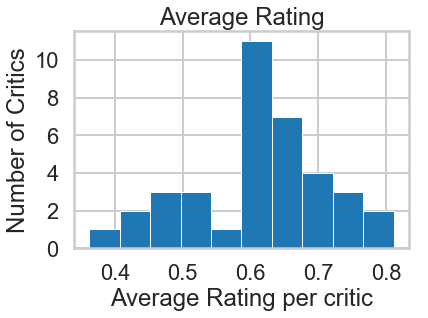

Average Rating Mean: 0.61


In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic


means_100 = means[counts > 100]
means_100.hist(edgecolor='w', lw=1)
plt.title('Average Rating')
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10])
plt.show()

print('Average Rating Mean: {:.2f}'.format(means_100.mean()))

**Critic's Average Rating Analysis**
>The average rating's distribution does not follow a normal distribution, but more of a bimodal distribution with two distributions; the distribution above average rating values of 0.6 resemble a half of the normal distribution, but average ratings below 0.6 see a sudden drop in the number of critics with those average ratings and have a distribution of their own. Lower average ratings seem to peak again around the 0.5 rating but with much lower number of critics than the peak around 0.6 average rating. An average rating value of 0.5 means that out of every two movies that a critic watches, the critic rates one of them as good and one of them as bad. Therefore, the peak in average ratings of 0.6 could correspond to critics airing on the side of good ratings, because the drastic change from normally distributed average ratings above 0.6 makes sense as critics should not rate every movie as good; however, the sudden drop in critics having an average rating less than 0.6 also means that critics stay away from giving bad reviews as much as possible. In conclusion, it can be noted that critics are more inclined to give a positive review rather than a bad review, and the sudden drop in the distribution of critics' average ratings below 0.6 is proof of that.

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](images/terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](images/vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](images/terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


**Note:**
Notice that the bag of words treatment doesn't preserve information about the *order* of words, just their frequency

In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

In [7]:
from sklearn.naive_bayes import MultinomialNB

# split data into train/test sets
X_train, X_test, y_train, y_test = sk_model.train_test_split(X, y)
# load classifier
def_nb = MultinomialNB()
# train classifier
def_nb.fit(X_train, y_train)
# accuracy scores
print('Train Accuracy: {:.2f}%'.format(def_nb.score(X_train, y_train) * 100))
print('Test Accuracy:  {:.2f}%'.format(def_nb.score(X_test, y_test) * 100))

Train Accuracy: 92.07%
Test Accuracy:  78.13%


**Simple Naive Bayes Results**
>The default Multinomial Naive Bayes is a really good classifier given there was no preprocessing done on the input features or any hyperparameters tuned. Without any of those things to help it perform better, the Multinomial Naive Bayes was still able to achieve an test accuracy of about 77%; however, a training accuracy of about 92% was reached which means that the model overfitted to the training data. Further work can be done on the model to close the gap between the training and testing accuracy which will help it generalize better to unseen data. 

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

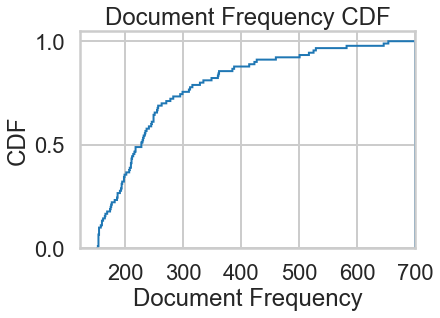

Min DF: 150
Max DF: 700


In [8]:
binary_cvec = CountVectorizer(lowercase=True, stop_words='english', binary=True,
                               min_df=150, max_df=700).fit(critics.quote)
binary_count = binary_cvec.transform(critics.quote).toarray()
df = np.sum(binary_count, axis=0)

# plot document frequency cdf
bins = np.arange(binary_cvec.min_df, binary_cvec.max_df + 1)
plt.hist(df, bins=bins, cumulative=True, density=True, histtype='step')
plt.xlim(right=binary_cvec.max_df)
plt.xlabel('Document Frequency')
plt.ylabel('CDF')
plt.xticks(bins[bins % 100 == 0])
plt.title('Document Frequency CDF')
plt.show()

print("Min DF:", binary_cvec.min_df)
print('Max DF:', binary_cvec.max_df)

**min_df, max_df**
> A `min_df` value of 150 was selected, since this would cut out any words that did not appear in at least 1% of all the reviews. A `max_df` value of 700 was selected, because the number of words appearing in more than 700 were so few that they could be interpreted as noise due to their unproportionate document frequencies; a of 700 corresponds to the document frequency value where the CDF plot begins to plateu.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [9]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [10]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

**Log-Likelihood Score**
> The log-likelihood score is a negative value returned by the classifier which is calculated by taking the log of a probability; the closer a probability is to 1, the closer to 0 the log-likelihood score is, but the further the probability is from 1, the more negative a value becomes. In order to get the best log-likelihood value, which corresponds to the negative value closest to 0, the classifier has to predict probabilities as close as possible to 1 for the correct class; for example, when a classifier returns a close-to-1 probability that a review is "fresh" when it is a "fresh" review, the log-likelihood value is close to 0, but if it actually was a "rotten" review, the "rotten" probability would've been close to 0 and the log-likelihood a large negative number. Therefore, the best log-likehood can be achieved by the classifier that is both most certain and accurate, because it receives a high penalty for being inaccurate.

**$\alpha$**
> If an alpha value is set too high, the model will treat words with less document frequencies the same, because the weight of the words with a low document frequency will be negligible in comparison to the $\alpha$ value chosen. The way alpha is incorporated into the probability function can be seen in this equation: $$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$


We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [11]:
from sklearn.model_selection import train_test_split

_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

In [12]:
#the grid of parameters to search over
alphas = [0.1, 1, 5, 10, 50]
best_min_df = 150

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[~mask]
    ytrainthis = ythis[~mask]
    clf = MultinomialNB(alpha=alpha)
    score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
    if score > maxscore:
        best_alpha = alpha
        maxscore = score
        
print("Best Score: {:.2f}".format(maxscore))        
print("Best Alpha: {}".format(best_alpha))        

Best Score: -1370.20
Best Alpha: 10


In [13]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain = X[~mask]
ytrain = y[~mask]
xtest = X[mask]
ytest = y[mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:.2f}%".format(training_accuracy * 100))
print("Accuracy on test data:     {:.2f}%".format(test_accuracy * 100))

from sklearn.metrics import confusion_matrix
conf_mat = pd.DataFrame(confusion_matrix(ytest, clf.predict(xtest)))
conf_mat.rename(columns={0:'Pred Rotten', 1:'Pred Fresh'}, 
                index={0:'True Rotten', 1:'True Fresh'})

Accuracy on training data: 66.48%
Accuracy on test data:     65.11%


,Pred Rotten,Pred Fresh
True Rotten,718,1113
True Fresh,516,2322


**Best Alpha & Min_DF**
> After using the best min_df and alpha values, the accuracy of the model on the test dataset decreased by about 13%; even though the generalization of the model did improve, where the gap between the training and testing accuracy dropped to about 2%, it ended up decreasing the test accuracy overall. This could've been caused by setting the min_df too high which could have cut off some important words, even if they had very low document frequencies; also, the alpha could have been set too high to the point where the model generalized too much and probabilities became uncertain, around the 50% range. 

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [14]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
        entertaining 0.85
       entertainment 0.82
         performance 0.82
               great 0.79
                best 0.78
               years 0.77
            american 0.77
        performances 0.76
                ever 0.75
               world 0.75
Bad words	     P(fresh | word)
               seems 0.46
               would 0.45
                much 0.45
                seem 0.45
               doesn 0.44
             nothing 0.41
                 isn 0.41
              really 0.37
                 too 0.35
                 bad 0.33


**Method for Deriving Predictive Features Explained**
>Doing this allows us to see what the probability of a movie being fresh given a word, because each row of the identity matrix represents a review containing a different word in the full vocabulary of the vectorizer. Therefore, by running the classifier on the identity matrix with rows equal to the length of the vocabulary, we can get the probability the classifier assigns to a word. This could help us select the most polar words which correspond to really high/low probabilities, and treat words close to the 50% range as noise.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [15]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
The most notable aspect of this trashy (but unenjoyable) biopic of Jacquleine Susann, Valley of the Doll's best-selling author, is its running time (93 minutes); Bette Midler and Nathan Lane give two of their worst and broadest performances.

Take away a couple of neatly staged action sequences and you're left with a callously measured slab of US jingoism that deals with the most horrific human tragedies in the most lunk-headed and insulting way possible.

Everytime I see one of these antiseptic Disney films, I'm reminded of the thrills and genuine artistry that went into the studio's films during its golden age in the 1940s and 1950s.

This is both the movie in which [Russell] is most faithful to the ideas and tone of his material, and one of his very worst films.

Directed with composure, but no great fervour, the film's conspicuously uninterested in American football, and much concerned with testing the limits and the resilienc

#### Classifying a Misleading Quote 
Quote: `This movie is not remarkable, touching, or superb in any way`

In [16]:
extra_quote = ['This movie is not remarkable, touching, or superb in any way']
extra_vec = vectorizer.transform(extra_quote)
extra_prob = clf.predict_proba(extra_vec)
print('Rotten Probability: {:.2f}%'.format(extra_prob[0][0]))
print('Fresh Probability: {:.2f}%'.format(extra_prob[0][1]))

Rotten Probability: 0.56%
Fresh Probability: 0.44%


**Analyzing Probabilities**
>Even though the quote is clearly representing a negative, or "rotten", movie review, the MultiNomialNB model believes it to be about 50/50 either way. This makes sense, because the MultiNomial Naive Bayes model uses the probability of a word being in a positive or negative review as a strong predictor, and the words contained in this review are mostly positive; however, the use of the word "not" could be strongly associated with negative reviews, and since the model does not take into consideration the context of words, the word "not" is enough to tip the scales in favor of a rotten review. 

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

### Using a Neural Network to Predict Sentiment

In [17]:
# create features and target dataset
deep_vect = CountVectorizer()
X_deep = deep_vect.fit_transform(critics.quote)
sentiment = (critics.fresh == 'fresh').values.astype(np.int)

# split data into train/test sets
X_train, X_test, y_train, y_test = sk_model.train_test_split(X_deep, sentiment)

In [18]:
from keras.models import Sequential
import keras.layers as layer

# create model
model = Sequential()
model.add(layer.Dense(25, input_dim=22417, activation='relu'))
model.add(layer.Dropout(0.5))
model.add(layer.Dense(1, activation='sigmoid'))

# compile model and print model summary
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                560450    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 560,476
Trainable params: 560,476
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fit model to training data
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=3, batch_size=16, verbose=1)

# test model accuracy on test dataset
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}%".format(scores[1] * 100))

Train on 11670 samples, validate on 3891 samples
Epoch 1/3
11670/11670 [==============================] - 13s 1ms/step - loss: 0.5985 - acc: 0.6729 - val_loss: 0.5125 - val_acc: 0.7553
Epoch 2/3
11670/11670 [==============================] - 12s 1ms/step - loss: 0.4169 - acc: 0.8254 - val_loss: 0.4724 - val_acc: 0.7797
Epoch 3/3
11670/11670 [==============================] - 13s 1ms/step - loss: 0.2863 - acc: 0.8923 - val_loss: 0.4782 - val_acc: 0.7859
Test Accuracy: 78.59%


**Neural Network & Sentiment Analysis**
> Sklearn's `CountVectorizer` was used to transform the critics' quotes into an matrix of integers representing a word's count in that quote, where each column represented a different word and the rows a different quote. Then a simple neural network was trained to predict the sentiment of the critics' quotes. Since the Multinomial NB model was able to achieve an accuracy score of about 77% very consistently, the goal of the neural network was to achieve a test accuracy score of at least 78%; the final model was able to achieve a final score of 78.59%. The network's architecture consisted of two dense layers; the first dense layer received an input of 22417 columns, is composed of 25 nodes and has a 'relu' activation function, and the second dense layer had a 'sigmoid' activation function with a single output corresponding to the probability of a quote corresponding to a 'fresh' review. A dropout layer is used in between both layers in order to slow down overfitting to the training data, and a batch size of 16 was used to update weights more frequently. Finally, 'binary crossentropy' was set as the loss function, the 'adam' optimizer was used to update weights and 'accuracy' was used to measure the performance of the model; within 3 epochs, the model was able to achieve an accuracy greater than 78% consistently.